In [2]:
# https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
import cv2
import numpy as np
import json
import shutil
import os
import glob
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv


In [3]:
class setup:
    algo = 'MOG2'

In [4]:
basepath = '../data/islands/images/images/' # refactor to match path naming
metadata_path = '../data/islands/metadata.json'
seq_path = '../data/testseq/'
with open(metadata_path) as f:
    d = json.load(f)

In [5]:
#create Background Subtractor objects
if setup.algo == 'MOG2':
    backSub = cv2.createBackgroundSubtractorMOG2()
else:
    backSub = cv2.createBackgroundSubtractorKNN()

In [91]:
idx = 8543
#idx = 4232 #coolfox2
# idx = 4324 #coolfox1
myseqid = d['images'][idx].get('seq_id')


In [92]:
myimgpaths = [basepath + img.get('file_name') for img in d['images'] if img.get('seq_id') == myseqid]

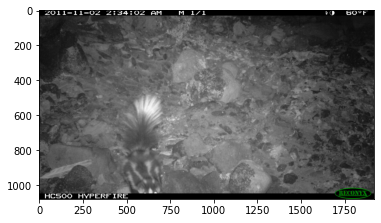

In [93]:
plt.imshow(cv2.imread(myimgpaths[3]))

c:\Projects\pyvenvs\wildsenv\lib\site-packages\matplotlib\_api\__init__.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if val not in values:


ValueError: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

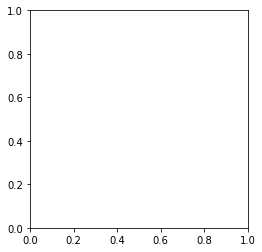

In [94]:
def getSequenceBGSub(seq_images):
    bgs = []
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
    for im in seq_images:
        tmp = fgbg.apply(im)
        bgs.append(tmp)
    return bgs

# TODO Fix empty: ValueError: zero-size array to reduction operation minimum which has no identity
def getBox(src):
    # https://stackoverflow.com/questions/60646384/python-opencv-background-subtraction-and-bounding-box
    src_gray = cv.cvtColor(src,cv.COLOR_BGR2GRAY)

    # adjust brightness
    src_bright = cv.convertScaleAbs(src_gray, alpha = 255.0/src.max(), beta = 0)
    # apply threshold
    threshold = 50
    _, img_thresh = cv.threshold(src_bright, threshold, 255, 0)
    # apply erode
    erosion_size = 7
    erosion_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    img_erosion = cv.erode(img_thresh, element)
    # apply dilate
    dilatation_size = 17
    dilatation_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    img_dilate = cv.dilate(img_erosion, element)

    # apply canny and find contours
    threshold = 50
    canny_output = cv.Canny(img_dilate, threshold, threshold * 2)
    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    xmax = ymax = 1
    xmin = ymin = 99999
    for c in contours:
        for cs in c:
            x, y = cs[0]
            if x > xmax: xmax = x
            if x < xmin: xmin = x
            if y > ymax: ymax = y
            if y < ymin: ymin = y
    return xmin, xmax, ymin, ymax

In [95]:
sequence_path = myimgpaths
seq_images = [cv2.imread(img) for img in sequence_path]


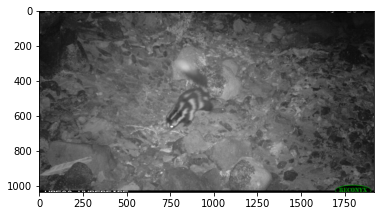

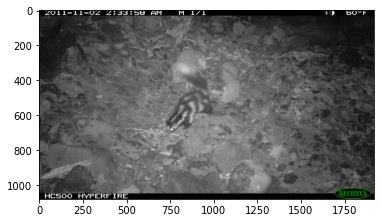

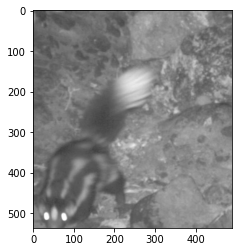

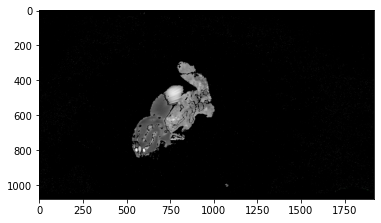

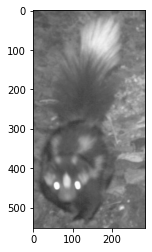

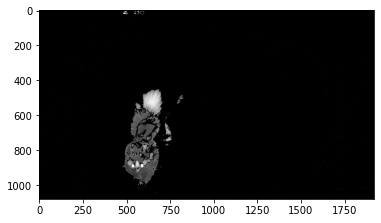

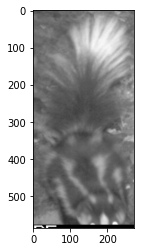

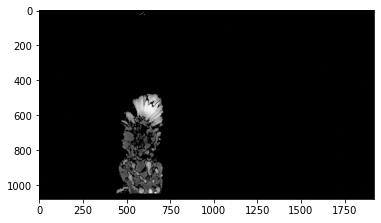

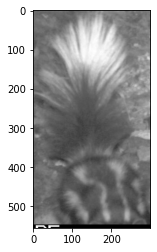

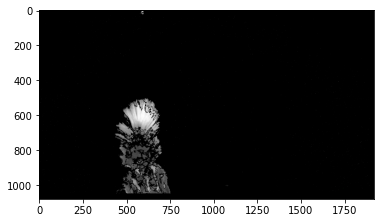

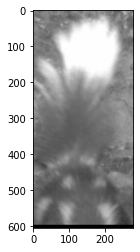

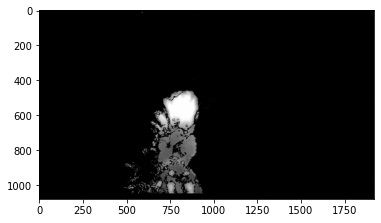

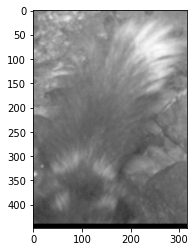

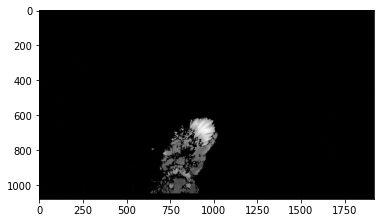

ValueError: zero-size array to reduction operation minimum which has no identity

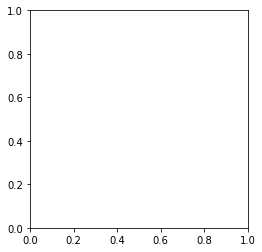

In [96]:
bgs = getSequenceBGSub(seq_images)
for i, bg in enumerate(bgs):
    boolbackground = bg != 0
    img = seq_images[i]
    img_booled = img * boolbackground[..., np.newaxis]
    xmin, xmax, ymin, ymax = getBox(img_booled)
    reshaped_img = img[ymin:ymax, xmin:xmax, :]
    plt.figure()
    plt.imshow(reshaped_img)
    plt.show()
    plt.figure()
    plt.imshow(img_booled)
    plt.show()

In [10]:
tmp = bgs[1] != 0

In [11]:
tmpimr = imr[1]
tmpimr *= tmp[..., np.newaxis]

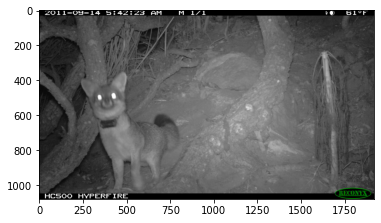

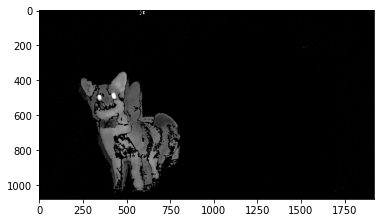

In [12]:
plt.imshow(tmpimr)

In [37]:
for c in contours:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / (M["m00"] + 0.0001))
	cY = int(M["m01"] / (M["m00"] + 0.0001))
	# draw the contour and center of the shape on the image
	cv2.drawContours(drawing, [c], -1, (0, 255, 0), 2)
	cv2.circle(drawing, (cX, cY), 7, (255, 255, 255), -1)
	cv2.putText(drawing, "center", (cX - 20, cY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

In [49]:
print(xmin, xmax, ymin, ymax)

229 809 342 1041


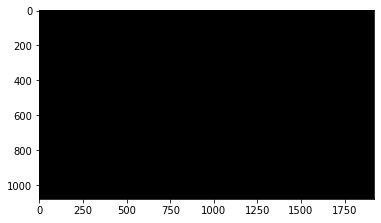

In [34]:

# apply approxPolyDP, hull, boundingRect and calculate areas for each contour
contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
areas = [None]*len(contours)
hull_list = []
for i, c in enumerate(contours):
    contours_poly[i] = cv.approxPolyDP(c, 3, True)
    hull_list.append(cv.convexHull(contours[i]))
    boundRect[i] = cv.boundingRect(contours_poly[i])
    areas[i] = cv.contourArea(c)

# set drawing 
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
# draw only the contour with the greatest area
i = areas.index(max(areas))
# color = (0,0,255)
# cv.drawContours(drawing, contours_poly, i, (0,255,0),2)
# cv.drawContours(drawing, hull_list, i, (255,0,0),2)
# cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
#   (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 3)

height, width, _ = src.shape
max_x = max_y = 0
min_x, min_y = width, height

for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv2.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 10 and h > 10:
      cv2.rectangle(drawing, (x,y), (x+w,y+h), (255, 0, 0), 2)

# # Alternatively, you can draw contours with area bigger than some value
# for i in range(len(contours[1])):
#     if areas[i] > 1000:
#         color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
#         cv.drawContours(drawing, contours_poly, i, color)
#         cv.drawContours(drawing, hull_list, i, color)
#         cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
#           (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)

# im = cv2.blend('blend',cv.add(drawing,src))
plt.imshow(drawing)

In [153]:
imr[1].shape


(1080, 1920, 3)

In [159]:
imheight, imwidth, _ = imr[1].shape
xmass, ymass = ndimage.center_of_mass(bgs[1])
xmass, ymass = xmass//1, ymass//1

xmin, xmax = int(max(0, xmass-320)), int(min(imwidth-1, xmass+320))
ymin, ymax = int(max(0, ymass-320)), int(min(imheight-1, ymass+320))

In [56]:
og = cv2.imread(myimgpaths[1])

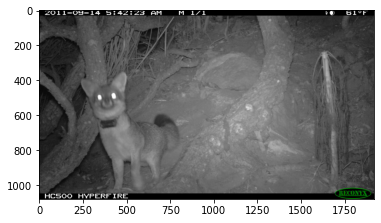

In [59]:
plt.imshow(og)

In [60]:
reshaped_img = og[ymin:ymax, xmin:xmax, :]

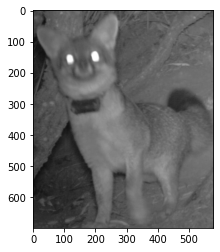

In [61]:
plt.imshow(reshaped_img) 

In [64]:
tmpimr2 = imr[1]

In [72]:
xmass, ymass = ndimage.center_of_mass(bgs[1])
xmass, ymass = xmass//1, ymass//1

(678.0, 534.0)

In [141]:
x,y,w,h = cv2.boundingRect(tmp)
cv2.rectangle(tmpimr,(x,y),(x+w,y+h),(0,255,0),2)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'boundingRect'
> Overload resolution failed:
>  - array data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'array'


In [74]:
threshold = 100
_, img_thresh = cv2.threshold(bgs[1], threshold, 255, 0)

In [71]:
tmp

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [77]:
img_thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [82]:
erosion_size = 7
erosion_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
img_erosion = cv2.erode(img_thresh, element)

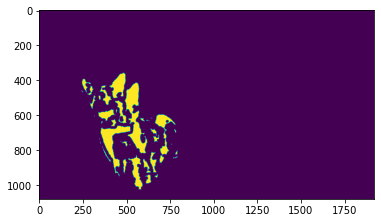

In [83]:
plt.imshow(img_erosion)

In [85]:
dilatation_size = 17
dilatation_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
img_dilate = cv2.dilate(img_erosion, element)

In [88]:
canny_output = cv2.Canny(img_dilate, threshold, threshold * 2)

In [121]:
contours, _ = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [130]:
contours

(array([[[598, 964]],
 
        [[598, 966]],
 
        [[600, 966]],
 
        [[600, 964]]], dtype=int32),
 array([[[593, 941]],
 
        [[593, 942]]], dtype=int32),
 array([[[587, 913]],
 
        [[587, 914]],
 
        [[586, 915]],
 
        [[586, 920]],
 
        [[587, 921]],
 
        [[587, 922]],
 
        [[590, 925]],
 
        [[590, 926]],
 
        [[591, 927]],
 
        [[591, 928]],
 
        [[592, 929]],
 
        [[592, 939]],
 
        [[591, 940]],
 
        [[591, 942]],
 
        [[591, 940]],
 
        [[592, 939]],
 
        [[592, 929]],
 
        [[591, 928]],
 
        [[591, 927]],
 
        [[590, 926]],
 
        [[590, 925]],
 
        [[589, 924]],
 
        [[589, 923]],
 
        [[586, 920]],
 
        [[586, 915]],
 
        [[588, 913]],
 
        [[589, 914]],
 
        [[589, 915]],
 
        [[590, 916]],
 
        [[590, 917]],
 
        [[593, 920]],
 
        [[594, 920]],
 
        [[595, 921]],
 
        [[596, 921]],
 
        [[597,

In [119]:
contours_poly = [None]*len(contours[1])
boundRect = [None]*len(contours[1])
areas = [None]*len(contours[1])
hull_list = []
for i, c in enumerate(contours[1]):
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    hull_list.append(cv2.convexHull(contours[1][i]))
    boundRect[i] = cv2.boundingRect(contours_poly[i])
    areas[i] = cv2.contourArea(c)

In [120]:
areas

[0.0, 0.0]

In [98]:
i = areas.index(max(areas))
color = (0,0,255)
cv2.drawContours(tmpimr2, contours_poly, i, (0,255,0),2)
cv2.drawContours(tmpimr2, hull_list, i, (255,0,0),2)
cv2.rectangle(tmpimr2, (int(boundRect[i][0]), int(boundRect[i][1])), \
  (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [113]:
i

0

TypeError: Invalid shape () for image data

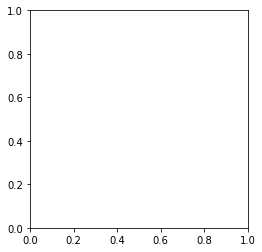

In [112]:
plt.imshow(i)

In [52]:
capture.read()

(False, None)

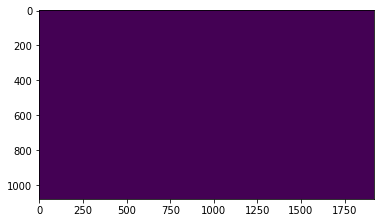

In [35]:
tmp = fgbg.apply(img[1])
plt.imshow(tmp)

In [ ]:
# for f in glob.glob(seq_path + '\*.jpg', recursive=True):
#     os.remove(f)
# for im in myimgpaths: 
#     newfile = shutil.copy2(im, seq_path)

# capture = cv2.VideoCapture(cv2.samples.findFileOrKeep(myimgpaths[0]))
# while True:
#     ret, frame = capture.read()
#     if frame is None:
#         break
#     fgMask = backSub.apply(frame)
#     gMask = backSub.apply(frame)
#     cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
#     cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
#     plt.imshow('frame', frame)
#     plt.imshow('fgmask', fgMask)
#     plt.show()
#     print('asdfasdf')